In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from thop import profile

import os
import matplotlib.pyplot as plt
import random
import copy
import numpy as np
import math

from MadeData import MadeData
from DNA import DNA
from StructMutation import StructMutation

# import global_var
from global_var import DNA_cnt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [2]:
class Model(torch.nn.Module):
    def __init__(self, DNA, parent_model=None):
        super(Model, self).__init__()
        self.dna = DNA
        self.layer_vertex = torch.nn.ModuleList()
        # print('init vertex', end='')
        for i, vertex in enumerate(DNA.vertices):
            # print('v{} '.format(i), end='')
            # 默认第一层和最后一层 vertex 非 hidden 层
            if vertex.type == 'bn_relu':
                self.layer_vertex.append(
                    torch.nn.Sequential(torch.nn.BatchNorm2d(vertex.input_channel),
                                        torch.nn.ReLU(inplace=True)))
            elif vertex.type == 'Global Pooling':
                self.layer_vertex.append(
                    torch.nn.Sequential(
                        # torch.nn.AdaptiveAvgPool2d((1, 1)),
                        torch.nn.Linear(vertex.input_channel, DNA.output_size_channel)))
            else:
                self.layer_vertex.append(None)

        self.layer_edge = torch.nn.ModuleList()
        # print('\ninit edges', end='')
        for i, edge in enumerate(DNA.edges):
            # TODO: 默认padding补全
            # print('e{}:'.format(i), end='')
            if edge.type == 'conv':
                # print('{},{},{} |'.format(edge.filter_half_height, edge.filter_half_width,edge.stride_scale),end=' ')
                temp = torch.nn.Conv2d(edge.input_channel,
                                       edge.output_channel,
                                       kernel_size=(edge.filter_half_height * 2 + 1,
                                                    edge.filter_half_width * 2 + 1),
                                       stride=pow(2, edge.stride_scale),
                                       padding=(edge.filter_half_height, edge.filter_half_width))
                if edge.model_id != -1 or parent_model == None:
                    temp.weight = parent_model.layer_edge[i].weight
                self.layer_edge.append(temp)
            else:
                # print(end=' |')
                self.layer_edge.append(None)
        # print('')
        self.batch_size = Evolution_pop.BATCH_SIZE

    def forward(self, input):
        '''
        配置每层的 输入、输出、激活函数
        '''
        block_h = input.shape[0]
        x = {
            0: input,
        }
        for index, layer_vert in enumerate(self.layer_vertex[1:], start=1):
            length = len(x)

            a = torch.empty(block_h, 0, 0, 0)
            for j, edg in enumerate(self.dna.vertices[index].edges_in):
                ind_edg = self.dna.edges.index(edg)
                ind_x = self.dna.vertices.index(edg.from_vertex)
                t = x[ind_x]
                if edg.type == 'conv':
                    t = self.layer_edge[ind_edg](x[ind_x])
                if j == 0:
                    a = torch.empty(block_h, 0, t.shape[2], t.shape[3])
                a = torch.cat((a, t), dim=1)

            if self.dna.vertices[index].type == 'linear':
                x[index] = a
            elif self.dna.vertices[index].type == 'bn_relu':
                x[index] = layer_vert(a)
            elif self.dna.vertices[index].type == 'Global Pooling':
                temp = torch.nn.AdaptiveAvgPool2d((1, 1))
                a = temp(a)
                a = torch.squeeze(a, 3)
                a = torch.squeeze(a, 2)
                x[index] = layer_vert(a)

        return x[len(x) - 1]


class Evolution_pop:
    _population_size_setpoint = 10
    _evolve_time = 100
    fitness_pool = []

    EPOCH = 3  # 训练整批数据多少次
    BATCH_SIZE = 50
    N_CLASSES = 10

    # LR = 0.001          # 学习率

    def __init__(self, data, pop_max=10, evolve_time=100):
        '''
        初始化DNA: 一层hidden(节点数不同); 都为linear
        接收传入的训练数据 data
        初始化 Mutation 类
        '''
        self.population = []
        self.model_stack = {}

        for i in range(self._population_size_setpoint):
            dna_iter = DNA()
            self.population.append(dna_iter)
            dna_iter.calculate_flow()
            self.model_stack[dna_iter.dna_cnt] = Model(dna_iter)

            global DNA_cnt
            DNA_cnt = self._population_size_setpoint

        self.data = data
        self.struct_mutation = StructMutation()

        self._population_size_setpoint = pop_max
        self._evolve_time = evolve_time

        self.fitness_dir = {}

    def decode(self):
        '''
         对当前population队列中的每个未训练过的个体进行训练 
         https://www.cnblogs.com/denny402/p/7520063.html
        '''
        for dna in self.population:
            if dna.fitness != -1.0:
                continue
            # TODO: 新训练的个体将fitness加入fitness_pool
            # dna.calculate_flow()
            # net = Model(dna)

            net = self.model_stack[dna.dna_cnt]
            print("[decode].[", dna.dna_cnt, "]", net)

            optimizer = torch.optim.Adam(net.parameters(), lr=dna.learning_rate)
            # the target label is not one-hotted
            loss_func = torch.nn.CrossEntropyLoss()

            train_loader, testloader = self.data.getData()
            # print("[Evolution_pop].[decode]->test_x: ", test_x.shape)
            accuracy = 0
            # training and testing
            for epoch in range(self.EPOCH):
                step = 0
                # TODO: 用movan的enumerate会报错，why?
                max_tep = int(60000 / train_loader.batch_size)

                train_acc = .0
                len_y = 0
                for step, (b_x, b_y) in enumerate(train_loader):
                    # print("[b_x, b_y].shape: ", b_x.shape, b_y.shape)
                    # 分配 batch data, normalize x when iterate train_loader
                    output = net(b_x)  # cnn output
                    idy = b_y.view(-1, 1)
                    # b_y = torch.zeros(self.BATCH_SIZE, 10).scatter_(1, idy, 1).long()

                    loss = loss_func(output, b_y)  # cross entropy loss
                    # clear gradients for this training step
                    optimizer.zero_grad()
                    loss.backward()  # backpropagation, compute gradients
                    optimizer.step()  # apply gradients

                    if step % 50 == 0:
                        pred = net(b_x)

                        print("\r" + 'Epoch: ' + str(epoch) + ' step: ' + str(step) + '[' +
                              ">>>" * int(step / 50) + ']',
                              end=' ')
                        # print('loss: %.4f' % loss.data.numpy(), '| accuracy: %.4f' % accuracy, end=' ')
                        print('loss: %.4f' % loss.data.numpy(), end=' ')
                print('')

            self.model_stack[dna.dna_cnt] = net
            # evaluation--------------------------------
            accuracy = self.Accuracy(net, testloader)
            input = torch.randn(self.BATCH_SIZE, dna.input_size_channel, dna.input_size_height,
                                dna.input_size_width)
            flops, params = profile(net, inputs=(input, ))
            print('----- Accuracy: {:.6f} Flops: {:.6f}-----'.format(accuracy, flops))
            # dna.fitness = eval_acc / len_y
            dna.fitness = accuracy
            self.fitness_dir[dna.dna_cnt] = accuracy
            print('')

    def Accuracy(self, net, testloader):
        ''' https://blog.csdn.net/Arctic_Beacon/article/details/85068188 '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        class_correct = list(0. for i in range(self.N_CLASSES))
        class_total = list(0. for i in range(self.N_CLASSES))
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(self.BATCH_SIZE):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        # for i in range(self.N_CLASSES):
        #     print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
        return sum(class_correct) / sum(class_total)

    def choose_varition_dna(self):
        '''
        每次挑选两个体,取fitness,判断要kill还是reproduce
        '''
        while self._evolve_time > 0:
            self._evolve_time -= 1
            self.decode()
            # 每次挑两个个体并提取出训练成绩fitness
            individual_pair = random.sample(list(enumerate(self.population)), 2)
            # TODO: 话说他这样取出来如果删掉的话真的能保证吗
            individual_pair.sort(key=lambda i: i[1].fitness, reverse=True)
            # better_individual = individual_pair[0]
            # worse_individual = individual_pair[1]
            # print("Choice: ",self._evolve_time,end=' ')
            # print("better: ",better_individual[0],'->',better_individual[1].fitness, end=' ')
            # print("worse: ", worse_individual[0],'->', worse_individual[1].fitness, end=' ')
            better_individual = individual_pair[0][0]
            worse_individual = individual_pair[1][0]
            individual_pair = []
            # (population过大->kill不好的)，反之(population过小->reproduce好的)
            if len(self.population) >= self._population_size_setpoint:
                print("--kill worse", worse_individual)
                self._kill_individual(worse_individual)
            elif len(self.population) < self._population_size_setpoint:
                print("--reproduce better", better_individual)
                self._reproduce_and_train_individual(better_individual)
        self.population.sort(key=lambda i: i.fitness, reverse=True)
        print(self.population[0].fitness)
        self.population[0].calculate_flow()
        # self.pop_show()

    def _kill_individual(self, index):
        ''' kill by the index of population '''
        # self._print_population()
        if self.population[index].dna_cnt in self.model_stack:
            del self.model_stack[self.population[index].dna_cnt]
        del self.population[index]

        # debug
        # self._print_population()

    def _reproduce_and_train_individual(self, index):
        ''' 
        inherit the parent, mutate, join the population 
        为了节省时间实际上有 Weight Inheritance
        '''
        # self._print_population()

        # inherit the parent (attention the dna_cnt)
        son = self.inherit_DNA(self.population[index])

        self.struct_mutation.mutate(son)
        son.calculate_flow()
        net = Model(son, self.model_stack[self.population[index].dna_cnt])

        self.model_stack[son.dna_cnt] = net
        self.population.append(son)
        # debug
        # self._print_population()

    def inherit_DNA(self, dna):
        ''' inderit from parent: reset dna_cnt, fitness '''
        son = copy.deepcopy(dna)
        global DNA_cnt
        son.dna_cnt = DNA_cnt
        DNA_cnt += 1
        son.fitness = -1
        return son

    def _print_population(self):
        print("pop sum: ", len(self.population), '|', end=' ')
        index = 0
        for i in self.population:
            print('(', index, '->', i.dna_cnt, ')', end=' ')
            index += 1
        print('')

    def pop_show(self):
        ''' 画出种群变化分布图 '''
        best_individual = self.population[0].dna_cnt
        live_individual = []
        for i in self.population:
            live_individual.append(i.dna_cnt)

        global DNA_cnt
        show_x = []
        show_y = []
        show_color = []
        for i in range(DNA_cnt + 1):
            if i in self.fitness_dir:
                show_x.append(i)
                show_y.append(self.fitness_dir[i])
                if i in live_individual:
                    if i == self.population[0].dna_cnt:
                        show_color.append('red')
                    else:
                        show_color.append('blue')
                else:
                    show_color.append('gray')
        plt.scatter(show_x, show_y, c=show_color, marker='.')
        plt.show()
        


vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.i_s0,N,N 
[calculate_flow] finish
vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.i_s0,N,N 
[calculate_flow] finish
vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.i_s0,N,N 
[calculate_flow] finish
vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.i_s0,N,N 
[calculate_flow] finish
vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.i_s0,N,N 
[calculate_flow] finish
vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.i_s0,N,N 
[calculate_flow] finish
vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.i_s0,N,N 
[calculate_flow] finish
vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.i_s0,N,N 
[calculate_flow] finish
vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.i_s0,N,N 
[calculate_flow] finish
vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.i_s0,N,N 
[calculate_flow] finish
[decode].[ 0 ] Model(
  (layer_vertex): ModuleList(
    (0): None
    (1): None
    (2): Sequential(
      (0): Linear(in_features=3, out_features=10, bias=True)
    )
  )
  (layer

Epoch: 0 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 2.1243  loss: 2.1857  loss: 2.3058  loss: 2.2513  loss: 2.1852  loss: 2.0563  loss: 2.1494  loss: 2.0366  loss: 1.9540  loss: 1.8798  loss: 1.9168  loss: 2.1638  loss: 1.9706  loss: 2.0469  loss: 2.0972  loss: 1.9287 
Epoch: 1 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 2.0638  loss: 2.1841  loss: 2.0705  loss: 2.1624  loss: 2.0502  loss: 2.1669  loss: 2.0329  loss: 1.9740  loss: 2.0259  loss: 2.0239  loss: 2.1377  loss: 2.1465  loss: 2.0671  loss: 2.0917  loss: 2.0088  loss: 1.9552 
Epoch: 2 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 2.0742  loss: 1.9121  loss: 2.2311  loss: 2.0818  loss: 2.3438  loss: 2.2814  loss: 2.0826  loss: 1.9562  loss: 1.8416  loss: 1.9875  loss: 2.0030  loss: 2.0213  loss: 2.1620  loss: 1.7864  loss: 1.8447  loss: 1.9249 
----- Accuracy: 0.280000 Flops: 11787000.000000-----

--kill worse 3
DNA [ 4 ]销毁->fitness 0.236
--repro

)
Epoch: 0 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 2.0332  loss: 1.8503  loss: 1.9845  loss: 1.9901  loss: 2.0729  loss: 2.0702  loss: 1.8500  loss: 1.9817  loss: 1.6881  loss: 1.9115  loss: 1.8992  loss: 1.9052  loss: 1.6555  loss: 1.9397  loss: 1.7766  loss: 1.9317 
Epoch: 1 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 1.6549  loss: 2.0046  loss: 1.6958  loss: 2.1009  loss: 1.7786  loss: 1.9070  loss: 1.6964  loss: 1.6961  loss: 2.0051  loss: 2.0370  loss: 1.9187  loss: 2.0252  loss: 1.7348  loss: 1.8775  loss: 1.6664  loss: 1.6355 
Epoch: 2 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 1.8243  loss: 1.7326  loss: 1.8288  loss: 2.0239  loss: 1.7369  loss: 1.8523  loss: 2.0342  loss: 1.6366  loss: 2.0272  loss: 1.8929  loss: 1.8922  loss: 1.8362  loss: 1.9769  loss: 1.9294  loss: 1.6714  loss: 2.0248 
----- Accuracy: 0.368000 Flops: 13218600.000000-----

--kill worse 3
DNA [ 13 ]销毁->fitness 0.356
--re

DNA [ 20 ]销毁->fitness 0.336
--reproduce better 1
outputs_mutable 1 0
vertex [ 1 ].0 , 0.i_s0,N,N 
vertex [ 2 ].0 , 1.c_s0,1,1 
vertex [ 3 ].0 , 2.c_s0,1,1 , 0.i_s0,N,N 
vertex [ 4 ].0 , 0.c_s0,1,1 , 3.i_s0,N,N , 1.i_s0,N,N 
[calculate_flow] finish
[decode].[ 31 ] Model(
  (layer_vertex): ModuleList(
    (0): None
    (1): None
    (2): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Linear(in_features=14, out_features=10, bias=True)
    )
  )
  (layer_edge): ModuleList(
    (0): None
    (1): None
    (2): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): None
    (5): None
    (6): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1

)
Epoch: 0 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 1.9276  loss: 1.9838  loss: 1.9321  loss: 1.7925  loss: 1.9677  loss: 1.7174  loss: 1.8276  loss: 1.7093  loss: 2.2130  loss: 2.0012  loss: 1.5739  loss: 1.8700  loss: 1.7465  loss: 1.8824  loss: 1.7119  loss: 2.0410 
Epoch: 1 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 1.7834  loss: 1.7739  loss: 2.0163  loss: 1.8167  loss: 2.0620  loss: 2.3216  loss: 1.8438  loss: 1.8700  loss: 1.7309  loss: 1.7461  loss: 1.8285  loss: 1.6436  loss: 1.6925  loss: 1.6695  loss: 1.8421  loss: 2.1989 
Epoch: 2 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 1.5574  loss: 1.5867  loss: 1.7302  loss: 1.8283  loss: 1.8217  loss: 2.0567  loss: 1.6952  loss: 1.6859  loss: 2.0381  loss: 1.8443  loss: 1.8041  loss: 1.8207  loss: 1.8240  loss: 1.6345  loss: 1.7873  loss: 1.8452 
----- Accuracy: 0.236000 Flops: 880056384.000000-----

--kill worse 9
DNA [ 35 ]销毁->fitness 0.236
--r

)
Epoch: 0 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 2.1055  loss: 1.9156  loss: 2.2170  loss: 1.8977  loss: 2.0843  loss: 1.9434  loss: 2.1551  loss: 1.9592  loss: 1.8430  loss: 1.7279  loss: 1.6511  loss: 1.6856  loss: 1.5665  loss: 1.9728  loss: 1.6765  loss: 1.7590 
Epoch: 1 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 1.9323  loss: 1.6446  loss: 1.8272  loss: 1.6703  loss: 1.7486  loss: 1.6358  loss: 1.8539  loss: 1.7527  loss: 1.7540  loss: 1.7611  loss: 2.0518  loss: 1.7140  loss: 1.7406  loss: 1.6594  loss: 1.6430  loss: 1.8955 
Epoch: 2 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 1.5695  loss: 1.5824  loss: 1.6848  loss: 1.6657  loss: 1.5679  loss: 1.8395  loss: 1.8721  loss: 1.8989  loss: 1.6094  loss: 1.5779  loss: 1.7799  loss: 1.6564  loss: 1.8039  loss: 1.7231  loss: 1.6892  loss: 1.8626 
----- Accuracy: 0.456000 Flops: 92402800.000000-----

--kill worse 0
DNA [ 16 ]销毁->fitness 0.364
--re

[decode].[ 46 ] Model(
  (layer_vertex): ModuleList(
    (0): None
    (1): None
    (2): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
    )
    (5): Sequential(
      (0): BatchNorm2d(55, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
    )
    (6): Sequential(
      (0): Linear(in_features=88, out_features=10, bias=True)
    )
  )
  (layer_edge): ModuleList(
    (0): None
    (1): None
    (2): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(3, 8, kernel_size=

vertex [ 5 ].0 , 4.i_s0,N,N , 0.c_s0,1,1 
vertex [ 6 ].0 , 1.c_s0,1,1 , 2.i_s0,N,N , 0.c_s0,1,1 , 3.c_s0,1,1 , 5.i_s0,N,N 
[calculate_flow] finish
[decode].[ 52 ] Model(
  (layer_vertex): ModuleList(
    (0): None
    (1): None
    (2): Sequential(
      (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): BatchNorm2d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
    )
    (5): Sequential(
      (0): BatchNorm2d(77, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
    )
    (6): Sequential(
      (0): Linear(in_features=125, out_features=10, bias=True)
    )
  )
  (layer_edge): ModuleList(
    (0): None
    (1): None
    (2): Conv2d(3, 5, kernel_si

)
Epoch: 0 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 1.9007  loss: 1.6427  loss: 1.7352  loss: 1.5919  loss: 1.4770  loss: 1.6273  loss: 1.5594  loss: 1.5901  loss: 1.6039  loss: 1.4006  loss: 1.7503  loss: 1.5352  loss: 1.6469  loss: 1.7016  loss: 1.3169  loss: 1.7937 
Epoch: 1 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 1.4346  loss: 1.3075  loss: 1.1408  loss: 1.6181  loss: 1.4100  loss: 1.4116  loss: 1.3310  loss: 1.3548  loss: 1.1961  loss: 1.3447  loss: 1.2918  loss: 1.1940  loss: 1.4790  loss: 1.1808  loss: 1.6241  loss: 1.4604 
Epoch: 2 step: 950[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]ss: 1.0872  loss: 1.4367  loss: 1.4342  loss: 1.1952  loss: 1.2110  loss: 1.6598  loss: 1.3657  loss: 1.2063  loss: 1.2192  loss: 1.0730  loss: 1.0988  loss: 1.2983  loss: 1.3260  loss: 1.3252  loss: 1.2293  loss: 1.2889 
----- Accuracy: 0.556000 Flops: 352154208.000000-----

--kill worse 3
DNA [ 50 ]销毁->fitness 0.524
--r

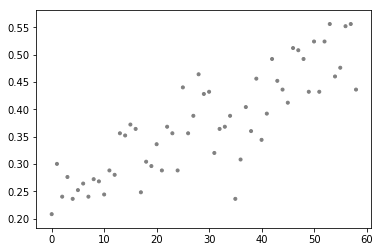

In [3]:
if __name__ == "__main__":
    data = MadeData()
    # 数据集选择
    train_loader, testloader = data.CIFR10()

    # test = Evolution_pop(train_loader, test_x, test_y)
    test = Evolution_pop(data, pop_max=10, evolve_time=100)
    test.choose_varition_dna()
    test.pop_show()

    print()

In [19]:
%whos

Variable         Type             Data/Info
-------------------------------------------
DNA              type             <class 'DNA.DNA'>
DNA_cnt          int              23
Data             module           <module 'torch.utils.data<...>tils\\data\\__init__.py'>
Evolution_pop    type             <class '__main__.Evolution_pop'>
F                module           <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
MadeData         type             <class 'MadeData.MadeData'>
Model            type             <class '__main__.Model'>
StructMutation   type             <class 'StructMutation.StructMutation'>
copy             module           <module 'copy' from 'D:\\<...>anaconda3\\lib\\copy.py'>
data             MadeData         <MadeData.MadeData object at 0x000001F70CB15908>
math             module           <module 'math' (built-in)>
np               module           <module 'numpy' from 'D:\<...>ges\\numpy\\__init__.py'>
os               module           <module 'os' from 'D:\\

['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'blue', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'blue', 'gray', 'gray', 'gray', 'blue', 'gray', 'gray', 'gray', 'gray', 'blue', 'red', 'gray', 'blue', 'blue', 'blue', 'blue']


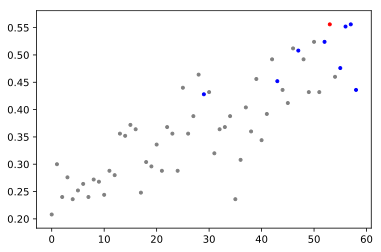

In [4]:
# def pop_show(self):
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
''' 画出种群变化分布图 '''
best_individual = test.population[0].dna_cnt
live_individual = []
for i in test.population:
    live_individual.append(i.dna_cnt)

global DNA_cnt
show_x = []
show_y = []
show_color = []
for i in range(DNA_cnt + 1):
    if i in test.fitness_dir:
        show_x.append(i)
        show_y.append(test.fitness_dir[i])
        if i in live_individual:
            if i == test.population[0].dna_cnt:
                show_color.append('red')
            else:
                show_color.append('blue')
        else:
            show_color.append('gray')


print(show_color)
plt.scatter(show_x, show_y, c=show_color, marker='.')
plt.show()